In [ ]:
---
skip_showdoc: true
---

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
skip_showdoc: true

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# key によるバッチ化

> Test

- skip_showdoc: true
- skip_exec: true

In [ ]:
#|default_exp KeyBatch

In [1]:

#| eval: false
#| hide
#| export
import numpy as np
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen, EKF, VA, Exper, Comp
from matplotlib import pyplot as plt
from typing import Tuple
from functools import partial
import pandas as pd

In [ ]:
#| eval: false
N=2
T=1000 
G =  1/2**7 * jnp.identity(N, dtype=jnp.float32)
Sigma = 1.5 * jnp.identity(N, dtype=jnp.float32)
w0 = 0*jnp.ones((N,), dtype=jnp.float32)/jnp.sqrt(N)
P0 = G
propy1 = 0.5

batched_exper = jax.vmap(
  lambda key: Comp.RMS(key, N, T, G, w0, Sigma, P0, propy1)
)

master_key = jrd.PRNGKey(0)
keys = jrd.split(master_key, 1000)

W_norms, RMS_EKF, RMS_VA, RMS_EM = batched_exper(keys)

<matplotlib.collections.PathCollection>

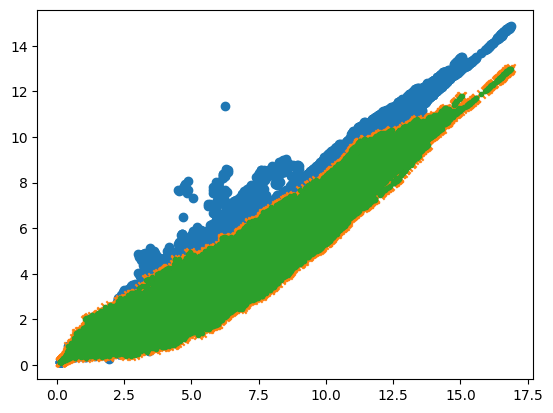

In [ ]:
#| eval: false
plt.scatter(W_norms.reshape(-1), RMS_EKF.reshape(-1))
plt.scatter(W_norms.reshape(-1), RMS_VA.reshape(-1), marker="x")
plt.scatter(W_norms.reshape(-1), RMS_EM.reshape(-1), marker=".")

In [ ]:
#| eval: false
# bin の定義
bins = jnp.arange(0.1, 12, 0.1)
bin_edges = jnp.arange(0.0, 12.1, 0.1)  # 例: [0.0, 0.1, 0.2, ..., 12.0]

# 各要素が属するビンを計算 (1~len(bins) のインデックス)
bin_idx = jnp.digitize(W_norms.ravel(), bin_edges) - 1  # shape (T*N,)

# フラット化
ekf_flat = RMS_EKF.ravel()
va_flat  = RMS_VA.ravel()
em_flat = RMS_EM.ravel()

# 各 bin ごとの総和とカウントを計算
sum_ekf = jnp.bincount(bin_idx, weights=ekf_flat, length=len(bins))
sum_va  = jnp.bincount(bin_idx, weights=va_flat,  length=len(bins))
sum_em  = jnp.bincount(bin_idx, weights=em_flat,  length=len(bins))
counts  = jnp.bincount(bin_idx, length=len(bins))

# 平均を計算（ゼロ除算防止）
mean_ekf = jnp.where(counts > 0, sum_ekf / counts, jnp.nan)
mean_va  = jnp.where(counts > 0, sum_va / counts, jnp.nan)
mean_em  = jnp.where(counts > 0, sum_em / counts, jnp.nan)

# 最終結果をまとめる
df_source = jnp.stack([bins, mean_ekf, mean_va, mean_em], axis=1)

# Pandas DataFrame に変換（必要なら）
df = pd.DataFrame(jnp.array(df_source), columns=["bin", "EKF_RMS", "VA_RMS", "EM_RMS"]).set_index("bin")

In [ ]:
#| eval: false
df[0.8:10].head(20)

,EKF_RMS,VA_RMS,EM_RMS
bin,,,
0.8,0.742320,0.743473,0.743350
0.9,0.839010,0.841791,0.841518
1.0,0.924905,0.927862,0.927469
1.1,1.016297,1.020453,1.019893
1.2,1.105977,1.110465,1.109501
1.3,1.174655,1.180493,1.179403
1.4,1.252368,1.259346,1.257725
1.5,1.327946,1.335311,1.333957
1.6,1.379003,1.375262,1.373536


<Axes: xlabel='bin'>

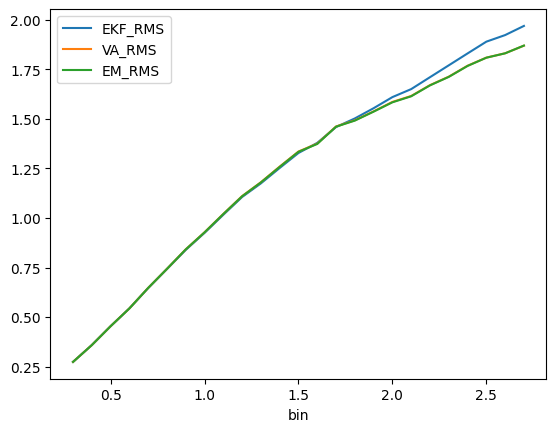

In [ ]:
#| eval: false
df[:2.7].plot()

In [ ]:
#| eval: false
N=10
T=1000 
G =  1/2**9 * jnp.identity(N, dtype=jnp.float32)
Sigma = 0.5 * jnp.identity(N, dtype=jnp.float32)
w0 = 0*jnp.ones((N,), dtype=jnp.float32)/jnp.sqrt(N)
P0 = G
propy1 = 0.5

batched_exper = jax.vmap(
  lambda key: Comp.losi_error(key, N, T, G, w0, Sigma, P0, propy1)
)

master_key = jrd.PRNGKey(0)
keys = jrd.split(master_key, 1000)

RMS_EKF, RMS_VA, RMS_EM = batched_exper(keys)

In [ ]:
#| eval: false
RMS_EKF.sum(), RMS_VA.sum(), RMS_EM.sum()

(Array(1.0641768e+07, dtype=float32),
 Array(8.087362e+06, dtype=float32),
 Array(8.100394e+06, dtype=float32))

In [ ]:
#| eval: false
Ns = [2, 4, 8]
Gs = jnp.array([1/2**4, 1/2**6, 1/2**8, 1/2**10, 1/2**12])
Sigmas = jnp.array([1/2**2, 1/2, 1, 2, 4, 8])
propy1s = jnp.array([0.5, 0.1])

import pandas as pd

# 最初に空の DataFrame を用意
df = pd.DataFrame(columns=["N", "G", "Sigma", "propy1", "err_EKF_sc", "err_VA_sc", "err_EM_sc"])

for N in Ns:
  print("N", N)
  for G_ in Gs:
    print("G", G_)
    for Sigma_ in Sigmas:
      for propy1 in propy1s:
        T = 1000
        G = G_ * jnp.identity(N, dtype=jnp.float32)
        Sigma = Sigma_ * jnp.identity(N, dtype=jnp.float32)
        w0 = 0*jnp.ones((N,), dtype=jnp.float32)/jnp.sqrt(N)
        P0 = G
        batched_exper = jax.vmap(
          lambda key: Comp.losi_error(key, N, T, G, w0, Sigma, P0, propy1),
          in_axes=(0,)
        )
        master_key = jrd.PRNGKey(0)
        keys = jrd.split(master_key, 1000)

        err_EKF, err_VA, err_EM = batched_exper(keys)

        err_EKF_sc = jnp.sqrt(err_EKF.mean())
        err_VA_sc = jnp.sqrt(err_VA.mean())
        err_EM_sc = jnp.sqrt(err_EM.mean())

        # pandas df に追加
        df.loc[len(df)] = [
            int(N),
            float(G_),
            float(Sigma_),
            float(propy1),
            float(err_EKF_sc),
            float(err_VA_sc),
            float(err_EM_sc)
        ]

print(df.head())

N 2
G 0.0625
G 0.015625
G 0.00390625
G 0.0009765625
G 0.00024414062
N 4
G 0.0625
G 0.015625
G 0.00390625
G 0.0009765625
G 0.00024414062
N 8
G 0.0625
G 0.015625
G 0.00390625
G 0.0009765625
G 0.00024414062
     N       G  Sigma  propy1  err_EKF_sc  err_VA_sc  err_EM_sc
0  2.0  0.0625   0.25     0.5    0.092954   0.093325   0.093123
1  2.0  0.0625   0.25     0.1    0.092736   0.093197   0.092990
2  2.0  0.0625   0.50     0.5    0.093420   0.093336   0.093043
3  2.0  0.0625   0.50     0.1    0.093356   0.093240   0.092941
4  2.0  0.0625   1.00     0.5    0.093443   0.091697   0.091294


,N,G,Sigma,propy1,err_EKF_sc,err_VA_sc,err_EM_sc
2,2.0,0.062500,0.50,0.5,0.093420,0.093336,0.093043
4,2.0,0.062500,1.00,0.5,0.093443,0.091697,0.091294
6,2.0,0.062500,2.00,0.5,0.093836,0.089228,0.088805
8,2.0,0.062500,4.00,0.5,0.094327,0.086147,0.085870
10,2.0,0.062500,8.00,0.5,0.096139,0.082455,0.082723
18,2.0,0.015625,2.00,0.5,0.093420,0.093336,0.093043
20,2.0,0.015625,4.00,0.5,0.093443,0.091697,0.091294
22,2.0,0.015625,8.00,0.5,0.093836,0.089228,0.088805
34,2.0,0.003906,8.00,0.5,0.093420,0.093336,0.093043
48,2.0,0.000244,0.25,0.5,0.039164,0.039163,0.039163


In [ ]:
#| eval: false
df.groupby("propy1").mean()

,N,G,Sigma,err_EKF_sc,err_VA_sc,err_EM_sc
propy1,,,,,,
0.1,4.666667,0.01665,2.625,0.090087,0.087966,0.087953
0.5,4.666667,0.01665,2.625,0.090186,0.088121,0.088114


In [ ]:
#| eval: false
df1 = df[df["propy1"] == 0.5][["N", "G", "Sigma", "err_EKF_sc", "err_VA_sc", "err_EM_sc"]]

In [ ]:
#| eval: false
df1.shape

(90, 7)

損失関数と同じ評価関数

$$E=\|\hat{\mathbf w}_{t} - \mathbf w_t\|^2$$

新たに導入した評価関数: $$E=\sqrt{\frac{1}{T}\sum_t^T\left(\left[\sigma(\mathbf w_t^T\mathbf x_t) - \sigma(\hat{\mathbf w}_{t-1}^T\mathbf x_t)\right]^2\right)}$$

### 次元数 $N$ に関しての比較
90 個のデータのうち、変分近似が拡張カルマンフィルタよりも $E$ が大きかったデータは
- $N=2$ : 20/30
- $N=4$ : 18/30
- $N=8$ :  5/30

In [ ]:
#| eval: false
df1[(df1["err_EKF_sc"] < df1["err_VA_sc"])].groupby("N").count()

,G,Sigma,err_EKF_sc,err_VA_sc,err_EM_sc
N,,,,,
2.0,20,20,20,20,20
4.0,18,18,18,18,18
8.0,5,5,5,5,5


遷移行列 $\boldsymbol\Gamma=pI$ に関しての比較
90 個のデータのうち、変分近似が拡張カルマンフィルタよりも $E$ が大きかったデータは
[1/2**4, 1/2**6, 1/2**8, 1/2**10, 1/2**12]
- $p = 1/2^{12}$ : 13/18
- $p = 1/2^{10}$ : 14/18
- $p = 1/2^8$ : 10/18
- $p = 1/2^6$ : 5/18
- $p = 1/2^4$ : 1/18

In [ ]:
#| eval: false
df1[(df1["err_EKF_sc"] < df1["err_VA_sc"])].groupby("G").count()

,N,Sigma,err_EKF_sc,err_VA_sc,err_EM_sc
G,,,,,
0.000244,13,13,13,13,13
0.000977,14,14,14,14,14
0.003906,10,10,10,10,10
0.015625,5,5,5,5,5
0.062500,1,1,1,1,1


$\mathbf x_t$ の共分散行列 $\Sigma=qI$ に関しての比較
[1/2**2, 1/2, 1, 2, 4, 8]
- $q = 1/2^2$ : 9/15
- $q = 1/2$ : 9/15
- $q = 1$ : 8/15
- $q = 2$ : 7/15
- $q = 4$ : 6/15
- $q = 8$ : 4/15

In [ ]:
#| eval: false
df1[(df1["err_EKF_sc"] < df1["err_VA_sc"])].groupby("Sigma").count()

,N,G,err_EKF_sc,err_VA_sc,err_EM_sc
Sigma,,,,,
0.25,9,9,9,9,9
0.50,9,9,9,9,9
1.00,8,8,8,8,8
2.00,7,7,7,7,7
4.00,6,6,6,6,6
8.00,4,4,4,4,4


<Axes: xlabel='G'>

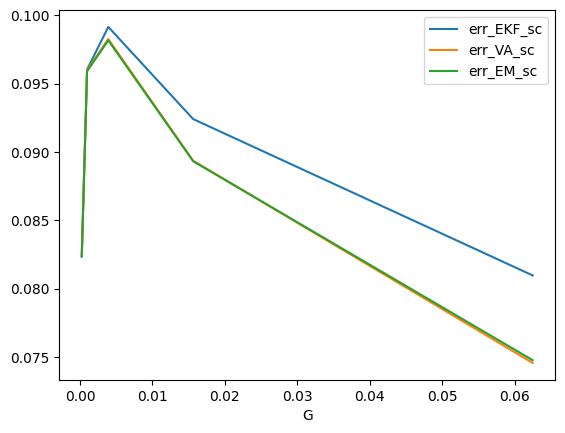

In [ ]:
#| eval: false
df1[["G", "err_EKF_sc", "err_VA_sc", "err_EM_sc"]].groupby("G").mean().plot()

<Axes: xlabel='Sigma'>

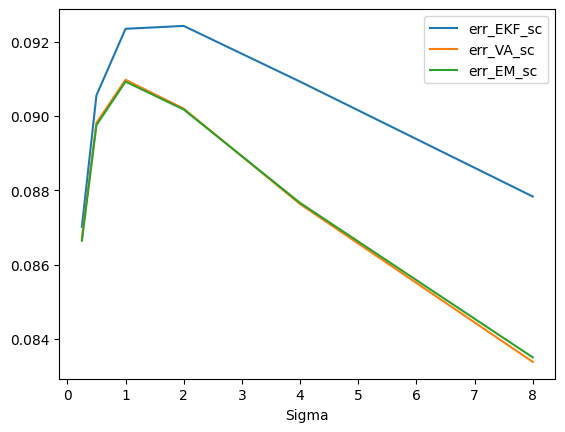

In [ ]:
#| eval: false
df1[["Sigma", "err_EKF_sc", "err_VA_sc", "err_EM_sc"]].groupby("Sigma").mean().plot()

<Axes: xlabel='N'>

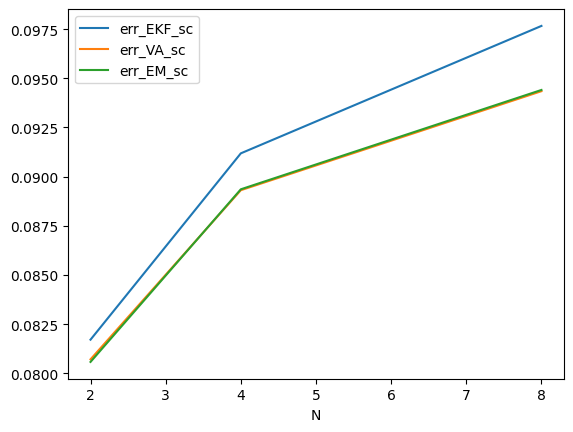

In [ ]:
#| eval: false
df1[["N", "err_EKF_sc", "err_VA_sc", "err_EM_sc"]].groupby("N").mean().plot()